In [1]:
# import dependencies 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import sys
import pickle 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)    
from processing_scripts import model_utils 

# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

In [2]:
# read in appeals data 
appeals = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/appeals_data_final.csv'))
appeals.info()

/Users/Gary/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9,103,107,115,116,117,196) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242466 entries, 0 to 242465
Columns: 232 entries, idncase to last_10_appeal_grant_by_judge_nat
dtypes: bool(1), float64(97), int64(41), object(93)
memory usage: 427.6+ MB


In [3]:
# read in non-appeals data 
non_appeals = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/non_appeals_data_final.csv'))
non_appeals.info()

/Users/Gary/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (36,103,104,107,115,116,117,120,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128720 entries, 0 to 128719
Columns: 231 entries, idncase to last_10_appeal_grant_by_judge_nat
dtypes: bool(1), float64(111), int64(43), object(76)
memory usage: 226.0+ MB


In [4]:
# model features used (TODO: save to pickle as well)
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'case_type_string', 'strCustody', 'strProbono', 
                'original_dec_type_string', 'original_dec_string']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year', 
                'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat']
IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero',
                  'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median',
                  'original_dec_type_string': 'none', 'original_dec_string': 'none'}

In [5]:
# subset out features used for model
appeals = appeals[CAT_FEATURES + NUM_FEATURES + ['idnproceeding']].copy() 
non_appeals = non_appeals[CAT_FEATURES + NUM_FEATURES + ['idnproceeding']].copy() 
non_appeals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128720 entries, 0 to 128719
Data columns (total 19 columns):
nat_grouped                          128720 non-null object
ij_code_grouped                      128720 non-null object
case_type_string                     128717 non-null object
strCustody                           0 non-null float64
strProbono                           0 non-null float64
original_dec_type_string             127309 non-null object
original_dec_string                  128709 non-null object
datAppealFiled_year                  128720 non-null int64
lawyer                               128720 non-null int64
defensive                            123900 non-null float64
affirmative                          123900 non-null float64
oral                                 127309 non-null float64
written                              127309 non-null float64
comp_year                            128720 non-null int64
osc_year                             128720 non-null int

### Prediction using aggregate model 

In [6]:
# process data 
X_agg = model_utils.transform_features(non_appeals, appeals, cat_features=CAT_FEATURES, 
                                   num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS)
X_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128720 entries, 0 to 128719
Columns: 541 entries, datAppealFiled_year to nat_grouped:::KOSOVO
dtypes: float64(11), uint8(530)
memory usage: 75.9 MB


In [7]:
# load model from pickle 
model_pkl_fname = "aggregate_random_forest_v0.pkl"
#model_pkl_fname = os.path.join(DATAFOLDER, 'aggregate_random_forest_v0.pkl') 
with open(model_pkl_fname, 'rb') as f:  
    agg_rf_model = pickle.load(f)

In [8]:
# predict on non-appeals 
pred = agg_rf_model.predict(X_agg)
print("""The model predicts that of the {} denied respondents that didn't appeal, {} ({:.1f}%) would have 
been successful had they appealed.""".format(len(pred), sum(pred), 100 * float(pred.sum()) / len(pred)))

The model predicts that of the 128720 denied respondents that didn't appeal, 13352 (10.4%) would have 
been successful had they appealed.


### Prediction using sequential models (1994-2013)

In [22]:
# combine appeals and non-appeals and predict together 
combined = pd.concat([appeals, non_appeals]) 
combined['appealed'] = np.where(combined['idnproceeding'].isin(appeals['idnproceeding']), 1, 0)
combined['appealed'].value_counts()

1    242466
0    128720
Name: appealed, dtype: int64

In [23]:
# load models from pickle 
seq_model_pkl_fname = "sequential_random_forest_v0.pkl"
with open(seq_model_pkl_fname, "rb") as f:
    sequential_models = pickle.load(f) 

In [24]:
# predict on non-appeals 

def sequential_model_prediction(df, appeals_df, cat_features, num_features, impute_methods, sequential_models): 
    """ Use sequential models to predict """
    
    # initialize empty dictionary to collect all results 
    sequential_predictions = []
    
    for i, year in enumerate(np.arange(1994, 2014, 1)): 
        _, X_test, _, _ = model_utils.get_model_data_by_year(
            df, appeals_df, label=None, unique_id='idnproceeding', cat_features=cat_features, 
            num_features=num_features, impute_methods = impute_methods, predict_year=year) 
        
        # datAppealFiled_year is included in X_train by default; remove if not in num_features
        if 'datAppealFiled_year' not in num_features: 
            X_test = X_test[[c for c in X_train.columns if c != 'datAppealFiled_year']]

        # run and append predictions 
        model = sequential_models[i]
        pred = pd.Series(data=model.predict(X_test), index=X_test.index.tolist())
        sequential_predictions.append(pred)
    
    return pd.DataFrame(pd.concat(sequential_predictions), columns=['pred']) 

In [25]:
sequential_predictions = sequential_model_prediction(df=combined, appeals_df=appeals,cat_features=CAT_FEATURES, 
                                                     num_features=NUM_FEATURES, impute_methods=IMPUTE_METHODS, 
                                                     sequential_models=sequential_models)

In [26]:
combined_pred = combined.merge(sequential_predictions, how='inner', left_on='idnproceeding', right_index=True) 

In [27]:
combined_pred.groupby('appealed')['pred'].mean()

appealed
0    0.117942
1    0.267513
Name: pred, dtype: float64

In [29]:
combined_pred.groupby(['appealed', 'pred']).size().unstack()

pred,0,1
appealed,,
0,98682,13195
1,157897,57666


In [34]:
print("{:.1f}% of those predicted to be successful did appeal".format(100 * 57666.0 / (13195 + 57666)))

81.4% of those predicted to be successful did appeal


In [40]:
print("""Only {:.1f}% of those who didn't appeal are predicted to successful, 
      compared with {:.1f}% of those who didn't appeal""".format(100 * 13195.0 / (98682 + 13195), 
                                                                 100 * 57666 / (57666 + 157897)))

Only 11.8% of those who didn't appeal are predicted to successful, 
      compared with 26.0% of those who didn't appeal


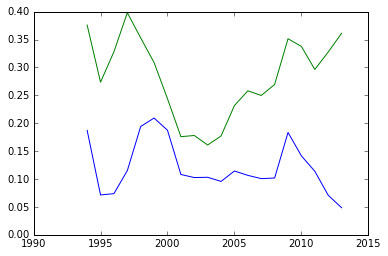

In [50]:
plt.plot(combined_pred.groupby(['datAppealFiled_year', 'appealed'])['pred'].mean().unstack())

In [41]:
# subset out those predicted to be successful, and see who are less likely to appeal 
pred_successes = combined_pred[combined_pred['pred'] == 1].copy() 

In [46]:
pred_successes.groupby('nat_grouped')['appealed'].agg(['size', np.mean]).sort_values(by='size', ascending=False)

,size,mean
nat_grouped,,
CHINA,12624,0.877060
EL SALVADOR,7913,0.671680
NICARAGUA,4056,0.846647
INDIA,3045,0.892939
COLOMBIA,2637,0.937050
GUATEMALA,2318,0.803710
HAITI,2094,0.872015
ARMENIA,1732,0.822171
ETHIOPIA,1573,0.825811


In [47]:
pred_successes.groupby('ij_code_grouped')['appealed'].agg(['size', np.mean]).sort_values(by='size', ascending=False)

,size,mean
ij_code_grouped,,
SH,1432,0.882682
BWS,911,0.905598
JVC,862,0.763341
BKS,834,0.907674
BHS,815,0.861350
WAC,797,0.435383
RW,746,0.839142
BAN,738,0.909214
WI,736,0.686141
